# Introduction

When it comes to building a ML model, there is a huge pool of models we can choose from. Given my limited time and computing resources, it can be challenging to choose the appropriate and usable models.

First, we have to decide which categories of ML models, is best suited for our task at hands. Is it classification, regression, or clustering. Typically, regression and classification are supervised learning, as in the models would be trained on labeled data, and compare the predictions with their actual values to see how far off is the result. Whereas clustering is a unsupervised learning technique, models are trained on unlabeled data, and the models will try to find patterns within the dataset and any relationship between individual data point.

In our case, we are trying to predict whether a guest is going to cancel his/her booking at a hotel. In the dataset we have the target variable we are trying to predict 'is_canceled', this leaves us in the field of classification. Now, there are numerous of classification algorithms we are use, in this notebook, I will pick a few to start with, and perform hyperparameter tuning and evaluate the models with different metrics.

**Models:**
- Logistic Regression
- LinearSVC
- KNN
- Decision Tree
- Random Forest
- XGBoost
- CatBoost
- ExtraTrees

**Resampling:**

From previous notebook of preprocessing, we saw there is imbalance in the dataset. Class imbalance can significantly affect the performance of machine learning models, especially in binary classification problems where one class (usually the minority class) is underrepresented compared to the other class (majority class). In our case, the models will not do a good job on canceled bookings.

In this notebook, I am applying and comparing following techniques, in order to resolve the effect of imbalance:
- SMOTE
- Undersampling

I am incorporating these two resampling techniques in a pipeline RandomizedSearchCV to see which one performs better.

*(Note: SMOTE doesn’t have a 'fit_transform' method, we cannot use it with 'Scikit-Learn' pipeline. I am using 'imblearn.pipeline' instead)*


**Hyperparameter Optimization:**

- RandomizedSearchCV vs GridSearchCV:
    - RandomizedSearchCV can find the optimal combination of hyperparameters in fewer iterations than in the grid search, it allows me to try a wider range of hyperparameters
    - I will use RandomizedSearchCV to loosely train the models first and compare their performances, then use GridSsearchCV to optimized the final model.<br>
     <br>              
- StratifiedKfold vs Kfold:
    - Stratified K-Fold ensures that each fold has a similar class distribution to the original dataset. This is crucial when dealing with imbalanced datasets 
    - In classification problems, it's essential to evaluate a model's performance for each class. Stratified K-Fold ensures that each class is represented in every fold, allowing you to assess the model's ability to distinguish between different classes.

**Evaluation Metrics:**

To identify the most suitable machine learning model for addressing the challenges posed by an imbalanced dataset, it's important to consider that accuracy alone may not be the most informative metric for evaluation. Instead, I will assess the models using metrics such as recall, precision, and F1 score, as these provide a more comprehensive understanding of their performance. Below, I provide a brief explanation of each metric:

- **Recall** (Sensitivity or True Positive Rate): Recall measures the ability of a model to correctly identify positive instances from all the actual positive instances. It is crucial when minimizing false negatives is a priority.
- When to Focus on Recall:
    - If false negatives (not predicting a cancellation when the booking is actually canceled) have a high cost, such as in cases where the hotel loses revenue due to unpreparedness for cancellations.
    - When you want to capture as many actual cancellations as possible, even if it means accepting more false positives.
    <br>
    <br>
- **Precision** (Positive Predictive Value): Precision quantifies the accuracy of positive predictions made by the model. It assesses the proportion of true positive predictions among all positive predictions. Precision is valuable when false positives should be minimized.
- When to Focus on Precision:
   - If false positives (predicting a cancellation when the booking isn't actually canceled) have a high cost, such as in cases where the hotel overbooks the room which is not actually canceled.
   - If you want to ensure that when the model predicts a cancellation, it's highly likely to be correct.
   <br>
   <br>
- **F1 Score**: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure of a model's performance, considering both false positives and false negatives. This metric is suitable when achieving a balance between precision and recall is essential.

- **Verdict**: In the context of hotel booking cancellations, we should consider both the operational and financial implications of false positives and false negatives. It is a common strategy for hotels to overbook some of their rooms to mitigate the costs of cancellations and no-shows. While high recall leads to cost savings and revenue optimization, a good balance between recall and precision can reduce the risk of false alarms and unnecessary actions, it may also lead to cautious and conservative decision-making, which can have associated costs in terms of revenue optimization, resource allocation, and customer experience. With that being said, the F1 score directly reflects the impact of model predictions on the hotel's bottom line. It quantifies the model's ability to optimize revenue by avoiding overbookings while minimizing missed revenue opportunities due to missed bookings.

# Imports

In [1]:
# import packages needed in this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# change the default style of plots
import matplotlib.style as style
style.use('dark_background')
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)


from scipy import stats
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
import xgboost as xgb
from catboost import CatBoostClassifier

from tempfile import mkdtemp
import joblib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

pd.options.display.max_columns = 250
pd.set_option('display.max_rows', None)

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

import time

In [2]:
df = pd.read_csv('hotel_preprocessed.csv')

In [3]:
# inspect
df.sample(3)

,is_canceled,lead_time,adults,children,is_repeated_guest,previous_bookings_not_canceled,booking_changes,company,days_in_waiting_list,adr,required_car_parking_spaces,total_stays,special_requests,arrival_date_month_sin,arrival_date_month_cos,arrival_date_day_of_month_sin,arrival_date_day_of_month_cos,hotel_City Hotel,arrival_date_year_2016,arrival_date_year_2017,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,deposit_type_No Deposit,deposit_type_Non Refund,customer_type_Contract,customer_type_Transient,customer_type_Transient-Party,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,agent_1,agent_6,agent_7,agent_8,agent_9,agent_14,agent_28,agent_40,agent_83,agent_85,agent_240,agent_241,agent_242,agent_250,agent_314,agent_No agent,agent_Other,country_AUT,country_BEL,country_BRA,country_CHE,country_CHN,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ITA,country_NLD,country_NOR,country_Other,country_POL,country_PRT,country_RUS,country_SWE,country_USA,meal_BB,meal_HB,meal_SC,previous_cancellations_Low,previous_cancellations_Medium,previous_cancellations_No,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_K
80871,0,92,2,0,0,0,0,0,0,164.7,0,2,0,0.500000,-0.866025,-0.299363,-0.954139,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
37674,1,12,2,0,0,0,0,0,0,93.0,0,1,1,0.866025,0.500000,0.988468,0.151428,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
54192,0,5,1,0,0,0,0,0,0,148.8,0,3,0,-0.866025,0.500000,0.988468,0.151428,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


# Split Dataset

In [4]:
# assign X and y
X = df.drop(columns='is_canceled')
y = df['is_canceled']

Recall that we saw imbalance in our target variable, let's deal with it now. I will use undersampling method for this instance, for the following reasons:
- the size of the dataset is large enough for us to remove some data points
- reduces computational cost 
- prevents models from overfitting

In [5]:
# check the target variable again
y.value_counts(normalize=True)

0    0.725005
1    0.274995
Name: is_canceled, dtype: float64

In [6]:
# splitting the dataset into remainder, and validation sets
X_remainder, X_validation, y_remainder, y_validation = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# splitting the remainder set into train, and test sets
X_train, X_test, y_train, y_test= train_test_split(X_remainder, y_remainder, test_size=0.25, random_state=42,stratify=y_remainder)

In [7]:
# check the shape of three sets
print(f'The shape of TRAIN set: {X_train.shape}{y_train.shape}.')
print(f'The shape of VALIDATION set: {X_validation.shape}{y_validation.shape}.')
print(f'The shape of TEST set: {X_test.shape}{y_test.shape}.')

The shape of TRAIN set: (52205, 95)(52205,).
The shape of VALIDATION set: (17402, 95)(17402,).
The shape of TEST set: (17402, 95)(17402,).


Recall that the data in the dataframe needs to be normalized, I am going to transform the training set first, then transform the validation and test sets based on the parameters of training set to avoid data leakage.

In [8]:
# instantiate MinMaxScaler
minmax = MinMaxScaler()

# fit transform split sets
X_train = minmax.fit_transform(X_train)
X_validation = minmax.transform(X_validation)
X_test = minmax.transform(X_test)

### Defining Fuctions

In this section, I will pre-define some functinos I will use in this notebook.

#### Feature Importance Table

In [9]:
def get_feature_importance(classifier, x_columns):
    
    # Get feature importances from the model
    feature_importance = classifier.feature_importances_

    # Create a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': x_columns, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    return feature_importance_df

#### Feature Selection

In [10]:
def feature_selector(classifier, X_train, y_train, X_validation, y_validation, feature_importance_df, thresholds):
    # note: pass in resampled split sets as needed   

    # Create an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['Minimum Importance', 'Train Accuracy', 'Validation Accuracy', 'Validation Recall', 'Validation Precision', 'Validation F1', 'Validation ROC/AUC', 'Model Runtime'])

    for importance in thresholds:
        
        # Start timing
        start_time = time.time()
        
        # Get the list of features whose importances are below the threshold
        redundant_features = list(feature_importance_df[feature_importance_df['Importance'] < importance]['Feature'])
        
        # Create new train and validation sets without redundant features
        X_train_new = X_train.drop(columns=redundant_features)
        X_validation_new = X_validation.drop(columns=redundant_features)
        
        # Fit on the new train set
        classifier.fit(X_train_new, y_train)

        # Predict
        y_pred = classifier.predict(X_validation_new)

        # Stop timing
        end_time = time.time()

        # Calculate the runtime in seconds
        runtime = round(end_time - start_time, 1)

        # Store the results in the DataFrame
        results_df = results_df.append({
            'Minimum Importance': importance,
            'Train Accuracy': round(classifier.score(X_train_new, y_train), 4),
            'Validation Accuracy': round(classifier.score(X_validation_new, y_validation), 4),
            'Validation Recall': round(recall_score(y_validation, y_pred), 4),
            'Validation Precision': round(precision_score(y_validation, y_pred), 4),
            'Validation F1': round(f1_score(y_validation, y_pred), 4),
            'Validation ROC/AUC': round(roc_auc_score(y_validation, classifier.predict_proba(X_validation_new)[:, 1]), 4),
            'Model Runtime': runtime
        }, ignore_index=True)

    results_df = results_df.set_index('Minimum Importance')
    
    return results_df

#### Drop Insignificant Features

In [11]:
def get_redundant(feature_importance_df, threshold):
    
    # get redundant features
    redundant_features = list(feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'])

    # print number of features to be dropped
    print(f'There are {len(redundant_features)} features to be removed')
    return redundant_features

## Modelling

For the modeling phase, I will assess and select the most effective model by initially conducting a loose preliminary hyperparameter optimization using RandomizedSearchCV for each model.

Given our imbalanced dataset, I will prioritize the F1 score as the evaluation metric, as accuracy is not a reliable indicator of model performance. After hyperparameter tuning, I will further fine-tune the model by adjusting prediction thresholds to find the optimal balance between recall and precision.

In [35]:
# define models and their hyperparameter grids

models = [
    {'model': LogisticRegression(),
     'param_grid': {
         'penalty': ['l1','l2'],
         'C': [0.01,0.1,1,10], 
         'solver': ['liblinear','saga'],
         'warm_start': [True, False]}
     },
    {'model': KNeighborsClassifier(),
     'param_grid': {
         'n_neighbors': np.arange(10,30,5),
         'weights': ['uniform', 'distance'], 
         'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
         'p': [1,2]}
     },
    {'model': SVC(probability=True),
     'param_grid': {
         'C': [0.01,0.1,1,10],
         'kernel': ['linear', 'rbf', 'sigmoid']}
     },
    {'model': DecisionTreeClassifier(),
     'param_grid': {
         'criterion': ["gini", "entropy", "log_loss"],
         'max_depth': np.arange(5,30,5), 
         'min_samples_split': np.arange(2,40,5),
         'min_samples_leaf': np.arange(1,40,5),
         'splitter': ['best','random']}
     },
    {'model': RandomForestClassifier(),
     'param_grid': {
         'criterion': ['gini', 'entropy', 'log_loss'],
         'n_estimators': np.arange(50,300,50),
         'max_depth': np.arange(5,35,5), 
         'max_features':['sqrt','log2',None],
         'min_samples_split': np.arange(2,30,5),
         'min_samples_leaf': np.arange(1,30,5),
         'warm_start': [True,False]}
     },
    {'model': xgb.XGBClassifier(),
     'param_grid': {
         'learning_rate': [0.1,0.2,0.5,1],
         'n_estimators': np.arange(50,300,50),
         'max_depth':np.arange(5,30,5), 
         'reg_alpha': [0.6,0.8,1.0,1.2,1.4],
         'reg_lambda': [0.6,0.8,1.0,1.2,1.4],
         'gamma': [0.4,0.8,1,1.2,1.4],
         'subsample': [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
         'colsample_bytree': [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
         'min_child_weight':np.arange(1,50,10)}
     },
    {'model': CatBoostClassifier(verbose=0),
     'param_grid': {
         'iterations': (100,200,500),       
         'learning_rate': [0.1,0.2,0.5,1], 
         'depth': np.arange(5,30,5),                
         'l2_leaf_reg': [1,3,5,7,9],         
         'border_count': [32,64,128],           
         'random_strength': [0.1,0.5,1.0],     
         'bagging_temperature': [0.0,1.0],       
         'border_count': [32,64,128],       
         'scale_pos_weight': [1,2,3]}
     },
     {'model': ExtraTreesClassifier(),
     'param_grid': {
         'n_estimators': np.arange(50,300,50),
         'criterion': ['gini', 'entropy', 'log_loss'],
         'max_depth': np.arange(5,30,5), 
         'max_features':['sqrt','log2',None],
         'min_samples_split': np.arange(2,30,5),
         'min_samples_leaf': np.arange(1,30,5),
         'warm_start': [True,False]}
     },
]      


# set up stratifiedkfold for cross validation
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=1)


# create a dictionary to store model performance metrics
results = []

for i in models:
    model = i['model']
    param_grid = i['param_grid']
    
    rs = RandomizedSearchCV(model,
                           param_grid,
                           n_iter=10,
                           scoring='f1',
                           cv=stratified_kfold,
                           n_jobs=-1)
    
    # fit
    rs.fit(X_train,y_train)
    
    # get best parameters and scores for each model
    best_model = rs.best_estimator_
    y_pred = rs.predict(X_validation)
    train_acc = rs.score(X_train,y_train)
    validation_acc = rs.score(X_validation,y_validation)
    precision = precision_score(y_validation,y_pred)
    recall = recall_score(y_validation,y_pred)
    f1 = f1_score(y_validation,y_pred)
    roc_auc = roc_auc_score(y_validation, rs.predict_proba(X_validation)[:,1])
    
    # store metrics in a nested dictionary
    results.append({
        'Model': model.__class__.__name__,
#         'Best Paramaters': rs.best_params_,
        'Train Accuracy': round(train_acc, 4),
        'Validation Accuracy': round(validation_acc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4),
        'ROC AUC': round(roc_auc, 4)
    })

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

In [36]:
# Convert the nested dictionary to a DataFrame
results_df = pd.DataFrame(results)
display(results_df)

,Model,Train Accuracy,Validation Accuracy,Precision,Recall,F1 Score,ROC AUC
0,LogisticRegression,0.6020,0.6094,0.6887,0.5465,0.6094,0.8656
1,KNeighborsClassifier,0.9962,0.6484,0.6687,0.6293,0.6484,0.8590
2,SVC,0.6665,0.6540,0.7192,0.5996,0.6540,0.8906
3,DecisionTreeClassifier,0.6997,0.6682,0.7113,0.6301,0.6682,0.8855
4,RandomForestClassifier,0.7631,0.6985,0.7392,0.6621,0.6985,0.9083
5,XGBClassifier,0.8525,0.7086,0.7358,0.6834,0.7086,0.9104
6,CatBoostClassifier,0.8256,0.7386,0.6778,0.8115,0.7386,0.9190
7,ExtraTreesClassifier,0.8791,0.7051,0.7350,0.6775,0.7051,0.9089


- Because there is imbalancee in the target variable, accuracy is not the ideal metric to evaluate the performance, as the model can underrepresent the minority class. In this case, since we need to addresss both false negatives and false positives, I will assess the performance based on F1 score.
- Overall, CatBoost is the best performing model. It has the highest validation accuracy, recall, F1 score and ROC AUC. 
- All the baseline models are overfitting, let's see after gridsearch if it is less prone to overfit.

## GridsearchCV CatBoost

In [30]:
# instantiate parameter grid
param_grid = {
        'iterations': (100,200,300,400,500),       
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
        'depth': np.arange(1,32,2),               
        'l2_leaf_reg': np.arange(1,22,2),       
        'border_count': [32, 64, 128, 256],       
        'random_strength': [0.1, 0.5, 1.0],    
        'bagging_temperature': [0.0, 1.0],     
        'border_count': [32, 64, 128],           
        'scale_pos_weight': [1, 2, 3],
}

# instantiate model
cat_gs = CatBoostClassifier(verbose=0)

# set up stratifiedkfold for cross validation
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=1)

# instantiate RandomizedSearhCV
cat_gs = RandomizedSearchCV(
    cat_gs,
    param_grid,
    n_iter=100,
    scoring='f1',
    cv=stratified_kfold,
    verbose=1,
    n_jobs=-1
)

# fit model
cat_gs.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fe28d5455b0>,
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bagging_temperature': [0.0, 1.0],
                                        'border_count': [32, 64, 128],
                                        'depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]),
                                        'iterations': (100, 200, 300, 400, 500),
                                        'l2_leaf_reg': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21]),
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3, 0.4, 0.5],
                                        'random_strength': [0.1, 0.5, 1.0],
                                        'scale_pos_weight': [1, 2, 3]},
                   scoring='f1', verbose=1)

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
/Users/yimingzhao/miniconda3/envs/deeplearning

/Users/yimingzhao/miniconda3/envs/deeplearning/lib/python3.8/site-packages/catboost/core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


In [32]:
# get best parameters
print("Best Hyperparameters: ", cat_gs.best_params_)
print("Best F1 Score: ", cat_gs.best_score_)

Best Hyperparameters:  {'scale_pos_weight': 2, 'random_strength': 0.5, 'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 9, 'border_count': 64, 'bagging_temperature': 0.0}
Best F1 Score:  0.7397171075076538


In [13]:
cat = CatBoostClassifier(scale_pos_weight=2,
                         random_strength=0.5,
                         learning_rate=0.05,
                         l2_leaf_reg=5,
                         iterations=500,
                         depth=9,
                         border_count=64,
                         bagging_temperature=0.0,
                         verbose=0)

cat.fit(X_train,y_train)

y_pred = cat.predict(X_validation)

train_acc = cat.score(X_train,y_train)
validation_acc = cat.score(X_validation,y_validation)
precision = precision_score(y_validation,y_pred)
recall = recall_score(y_validation,y_pred)
f1 = f1_score(y_validation,y_pred)
roc_auc = roc_auc_score(y_validation, cat.predict_proba(X_validation)[:,1])

In [14]:
print(f'Accuracy on train set: {round(train_acc,4)}') 
print(f'Accuracy on validation set: {round(validation_acc,4)}') 
print(f'Recall on validation set: {round(recall,4)}') 
print(f'Precision on validation set: {round(precision,4)}') 
print(f'F1 on validation set: {round(f1,4)}')
print(f'ROC/AUC on validation set: {round(roc_auc,4)}')

Accuracy on train set: 0.8877
Accuracy on validation set: 0.843
Recall on validation set: 0.8167
Precision on validation set: 0.6781
F1 on validation set: 0.741
ROC/AUC on validation set: 0.9199


Perfect, the validation accuracy improved by 11%, and less prone to overfit. The F1 score increased by 1.46%.

In [15]:
# put scaled data into dataframe
X_train = pd.DataFrame(X_train,columns=X.columns)
X_validation = pd.DataFrame(X_validation,columns=X.columns)
X_test = pd.DataFrame(X_test,columns=X.columns)

# get feature importances
cat_feature_importance = get_feature_importance(cat, X_train.columns)
cat_feature_importance

,Feature,Importance
67,country_PRT,14.044978
9,required_car_parking_spaces,10.214411
0,lead_time,8.678235
39,agent_9,5.465483
11,special_requests,4.650335
45,agent_240,3.517999
8,adr,3.400540
25,market_segment_Online TA,3.393689
17,arrival_date_year_2016,3.293607
18,arrival_date_year_2017,2.936593


Some features have little to no predictive value for the model, let's compare the model performance after removing some of the redundant features, I am doing this by training the model with different subset of features at various importance thresholds.

In [49]:
# list of thresholds
thresholds = [0.001,0.01,0.03,0.04,0.07,0.09,0.1,0.12,0.15]

# compare model performance at various thresholds
feature_selector(cat,
                 X_train,
                 y_train,
                 X_validation,
                 y_validation,
                 cat_feature_importance,
                 thresholds)

,Train Accuracy,Validation Accuracy,Validation Recall,Validation Precision,Validation F1,Validation ROC/AUC,Model Runtime
Minimum Importance,,,,,,,
0.001,0.8859,0.8419,0.8150,0.6763,0.7392,0.9198,6.6
0.010,0.8859,0.8430,0.8171,0.6780,0.7411,0.9200,6.3
0.030,0.8859,0.8422,0.8155,0.6768,0.7397,0.9197,6.1
0.040,0.8882,0.8436,0.8180,0.6789,0.7420,0.9202,6.0
0.070,0.8900,0.8426,0.8138,0.6782,0.7398,0.9195,6.1
0.090,0.8877,0.8417,0.8130,0.6766,0.7386,0.9192,6.2
0.100,0.8880,0.8432,0.8134,0.6796,0.7405,0.9190,6.2
0.120,0.8889,0.8428,0.8178,0.6773,0.7410,0.9198,5.9
0.150,0.8889,0.8424,0.8127,0.6780,0.7393,0.9190,5.9


At threshold 0.04 the model achieves the highest validaiton accuracy and F1 score. I will choose this as the optimal cutoff point.

In [16]:
# get features to be removed
print(get_redundant(cat_feature_importance,0.04))

There are 19 features to be removed
['days_in_waiting_list', 'assigned_room_type_C', 'country_POL', 'reserved_room_type_G', 'agent_6', 'distribution_channel_GDS', 'company', 'agent_28', 'agent_1', 'market_segment_Aviation', 'agent_85', 'reserved_room_type_C', 'assigned_room_type_K', 'country_NOR', 'reserved_room_type_H', 'previous_cancellations_Medium', 'market_segment_Complementary', 'agent_40', 'assigned_room_type_H']


The model's complexity is reduced by 19 features, also the performance is improved by a margin.

In [17]:
# drop redundant features
for x in [X_train, X_validation, X_test]:
    
    x = x.drop(columns=['days_in_waiting_list', 'assigned_room_type_C', 'country_POL', 'reserved_room_type_G', 'agent_6', 'distribution_channel_GDS', 'company', 'agent_28', 'agent_1', 'market_segment_Aviation', 'agent_85', 'reserved_room_type_C', 'assigned_room_type_K', 'country_NOR', 'reserved_room_type_H', 'previous_cancellations_Medium', 'market_segment_Complementary', 'agent_40', 'assigned_room_type_H'])
    
    # check shape
    print(x.shape)

(52205, 76)
(17402, 76)
(17402, 76)


Now, refit the optimized model and check how it performs on the test set.

In [18]:
# instantiate CatBoost
cat_test = CatBoostClassifier(scale_pos_weight=2,
                         random_strength=0.5,
                         learning_rate=0.05,
                         l2_leaf_reg=5,
                         iterations=500,
                         depth=9,
                         border_count=64,
                         bagging_temperature=0.0,
                         verbose=0,)

# refit
cat_test.fit(X_train,y_train)

# get model scores
y_pred = cat_test.predict(X_test)

train_acc = cat_test.score(X_train,y_train)
validation_acc = cat_test.score(X_test,y_test)
precision = precision_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
roc_auc = roc_auc_score(y_test, cat_test.predict_proba(X_test)[:,1])

print(f'Accuracy on train set: {round(train_acc,4)}') 
print(f'Accuracy on test set: {round(validation_acc,4)}') 
print(f'Recall on test set: {round(recall,4)}') 
print(f'Precision on test set: {round(precision,4)}') 
print(f'F1 on test set: {round(f1,4)}')
print(f'ROC/AUC on test set: {round(roc_auc,4)}')

Accuracy on train set: 0.8877
Accuracy on test set: 0.8424
Recall on test set: 0.8165
Precision on test set: 0.6771
F1 on test set: 0.7403
ROC/AUC on test set: 0.9198


We successfully reduced model complexity by 19 features while sacrificing minimal performance.

## Evaluation

Let's look at the confusion matrix and classification report of CatBoost to give us a baseline.

In [19]:
# classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.85      0.89     12616
           1       0.68      0.82      0.74      4786

    accuracy                           0.84     17402
   macro avg       0.80      0.83      0.81     17402
weighted avg       0.86      0.84      0.85     17402



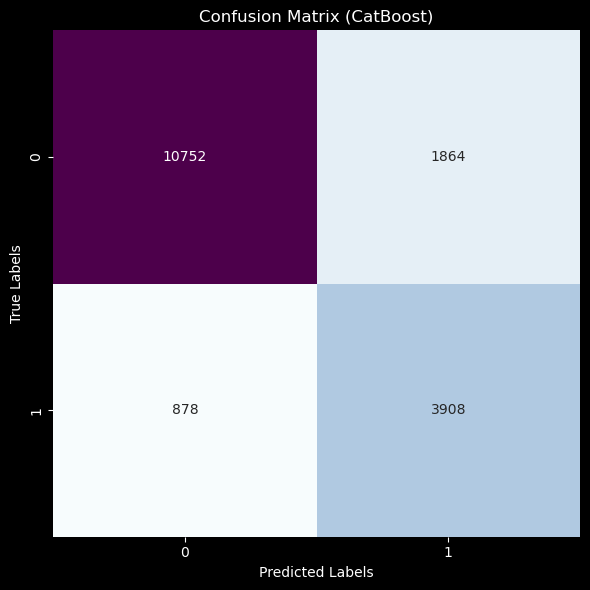

In [20]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
    
# plot
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (CatBoost)')
plt.tight_layout()
plt.show()

Among the 4786 bookings that were actually canceled, the model accurately predicted 3908 of them. And out of 12616 confirmed bookings, the model miscalssified 1864 as canceled.

The F1-scores provide a balance between precision and recall for each class, taking into account both false positives and false negatives. The weighted average F1-score (74%) reflects the overall model performance in distinguishing between canceled and not canceled bookings.

Overall, this model demonstrates reasonably good performance in predicting hotel booking cancellations, with a notable ability to correctly identify canceled bookings. However, further analysis and optimization may be needed based on specific business requirements and objectives.

### Feature Interpretation

In [21]:
# get feature importances from the model
feature_importance_cat_test = get_feature_importance(cat_test,X_test.columns).head(20)
feature_importance_cat_test

,Feature,Importance
67,country_PRT,14.044978
9,required_car_parking_spaces,10.214411
0,lead_time,8.678235
39,agent_9,5.465483
11,special_requests,4.650335
45,agent_240,3.517999
8,adr,3.400540
25,market_segment_Online TA,3.393689
17,arrival_date_year_2016,3.293607
18,arrival_date_year_2017,2.936593


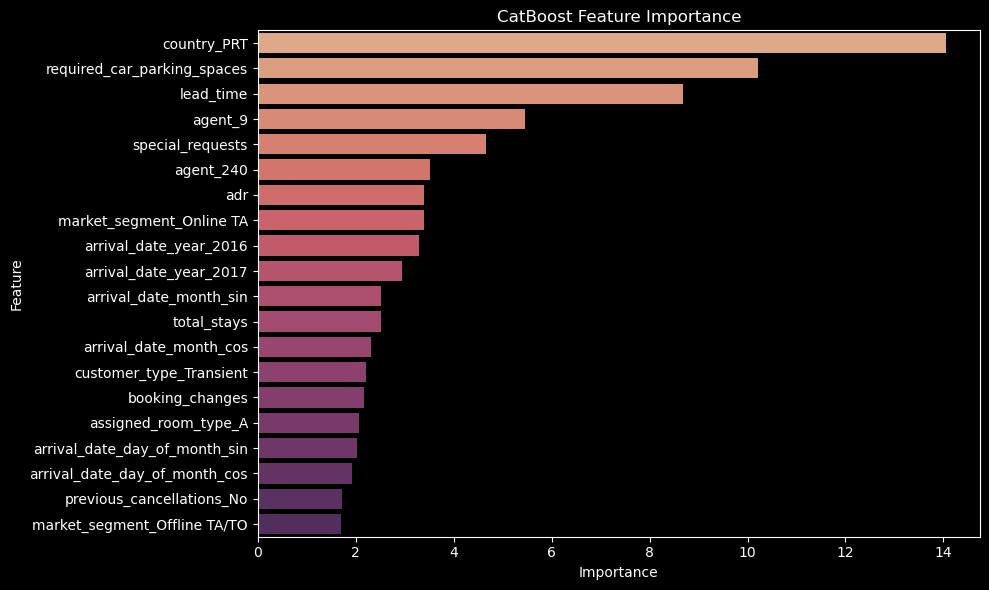

In [22]:
# Create the bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=feature_importance_cat_test,
            x='Importance',
            y='Feature',
            orient='h',
            palette='flare')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()

**Here are some of the most important takeaways from the model and EDA:**
- `Country Portugal` is the most predictive features for the model, as we saw in the EDA, guests who are from Portugal most likely to cancel their bookings
- Guests who made `car parking and special requests` and `specal requests` are least likely to cancel
- Longer `lead_time` result in higher cancel chance
- `Agent 9` has the lowest success rate of retaining the bookings

### Optimizing Predicting Threshold

In the classificaiton report, the model has a good recall on the minority class of 82%, while it only achieved 68% on precision, which means the model has relative high chance of misclassifying the confirmed bookings as cancellations. Based on previous discussion, when evaluating a model we should consider both false postives and false negatives. Next, I will explore an optimization approach based on the ROC curve to find an optimal balance between the two. My objective is to fine-tune the threshold value, aiming for the maximum number of correctly predicted true positives. Meaning, I will try to identify the threshold which satisfies the equation , while minimizing the FPR, it means the optimal threshold is where TPR + FPR - 1 &rarr; 0.

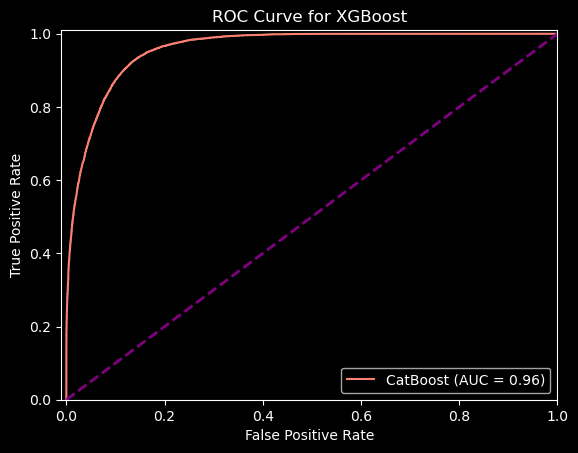

In [23]:
# get the ROC curve for train set
fpr, tpr, thresholds = roc_curve(y_train,
                                 cat_test.predict_proba(X_train)[:,1],
                                 drop_intermediate=False) 

# get the area under ROC curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1.5, color = 'salmon', label=f'CatBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='purple', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc='lower right')
plt.show()

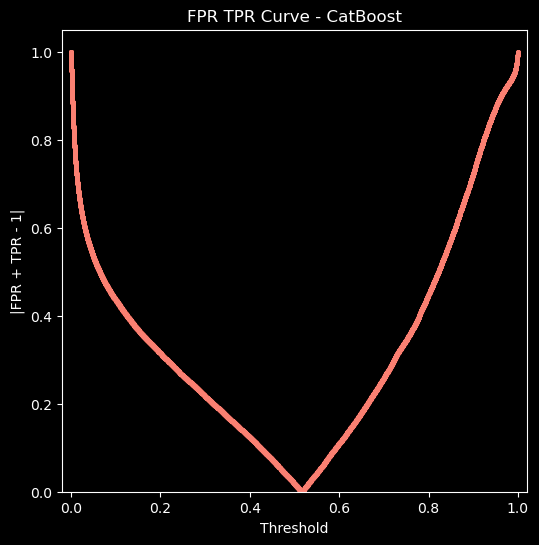

In [24]:
# define the equation we are evaluating the threholds with
scores = np.abs(fpr+tpr-1)

# plot
plt.figure(figsize = (6,6)) 
plt.scatter(thresholds,scores,color='salmon',s=5) 
plt.xlabel("Threshold") 
plt.ylabel("|FPR + TPR - 1|") 
plt.title("FPR TPR Curve - CatBoost")
plt.xlim([-0.02,1.02]) 
plt.ylim([0.0,1.05]) 
plt.show()

In [25]:
# get the threshold where fpr+tpr-1 is the closest to 0
min_index = np.argmin(scores)
predicting_threshold = thresholds[min_index]

print(f'The optimal threshold is at: {predicting_threshold}')

The optimal threshold is at: 0.515746074562227


We see that the curve has the lowest point at threshold around 0.516, where it gives us the largest true positive rate of the model. I will set the threshold for this value and predict the outcomes again. 

In [33]:
# classify base on the new threshold
y_pred_th = (cat_test.predict_proba(X_test)[:,1] > predicting_threshold).astype('float') 

# get scores
print(f'Recall on test set: {round(recall_score(y_test, y_pred_th),4)}') 
print(f'Precision on test set: {round(precision_score(y_test, y_pred_th),4)}') 
print(f'F1 on test set: {round(f1_score(y_test, y_pred_th),4)}')
print(f'ROC/AUC on test set: {round(roc_auc_score(y_test, cat_test.predict_proba(X_test)[:,1]),4)}') 

Recall on test set: 0.8036
Precision on test set: 0.6872
F1 on test set: 0.7408
ROC/AUC on test set: 0.9198


Let's look at the classification and compare the confusion matrix before and after adjusting the threshold.

In [34]:
# classification report
print(classification_report(y_test,y_pred_th))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89     12616
           1       0.69      0.80      0.74      4786

    accuracy                           0.85     17402
   macro avg       0.80      0.83      0.82     17402
weighted avg       0.86      0.85      0.85     17402



In [28]:
# confusion matrix after adjusting theshold
cm_th = confusion_matrix(y_test, y_pred_th)

Text(0.5, 1.0, 'Confusion Matrix (optimized threshold)')

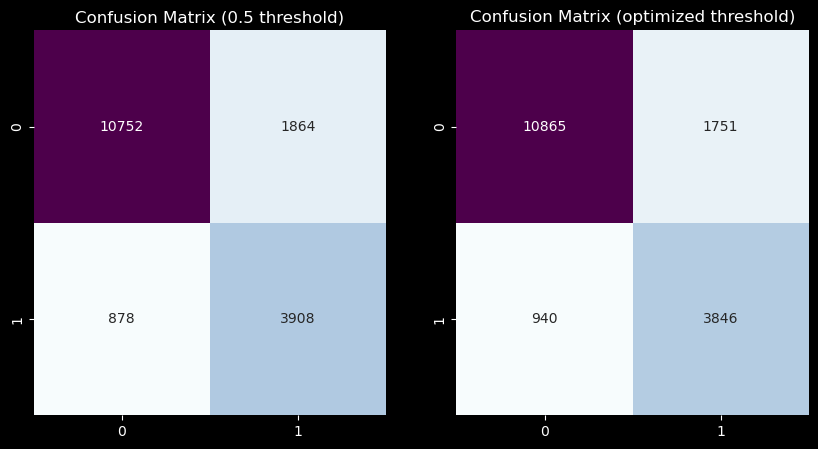

In [29]:
# subplots of before and after
fig,ax = plt.subplots(figsize=(10,5),nrows=1,ncols=2)

sns.heatmap(cm, annot=True, cmap='BuPu', fmt='g', cbar=False,ax=ax[0])
ax[0].set_title('Confusion Matrix (0.5 threshold)')

sns.heatmap(cm_th, annot=True, cmap='BuPu', fmt='g', cbar=False,ax=ax[1])
ax[1].set_title('Confusion Matrix (optimized threshold)')

The model's ability to accurately predict actual canceled bookings decreased by 62 instances, but it has become significantly more reliable in avoiding misclassifying non-canceled bookings as canceled, with a reduction of 113 such instances. This represents a favorable trade-off in performance.

We managed to optimize the precision at predicting threshold around 0.516, which gives the highest number of correctly predicted True positives without sacrificing too much precision.

## Dynamic Thresholding for Business Metrics

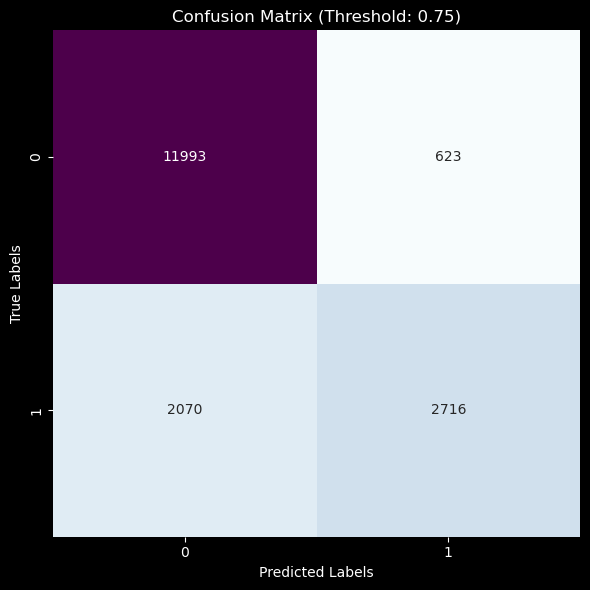

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     12616
           1       0.81      0.57      0.67      4786

    accuracy                           0.85     17402
   macro avg       0.83      0.76      0.78     17402
weighted avg       0.84      0.85      0.84     17402



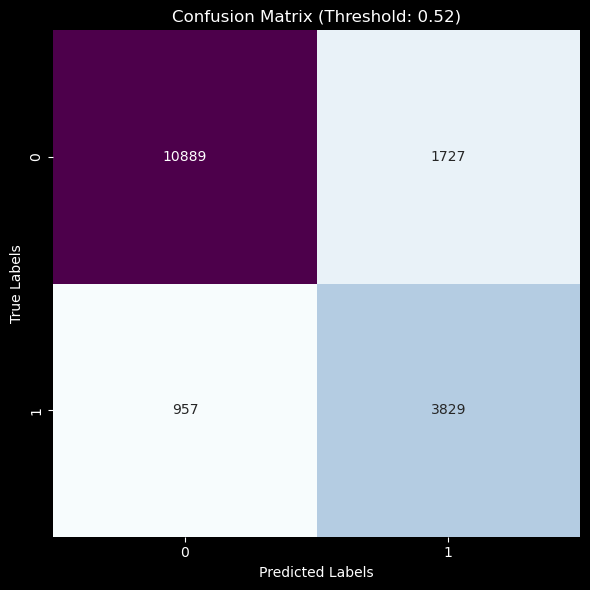

              precision    recall  f1-score   support

           0       0.92      0.86      0.89     12616
           1       0.69      0.80      0.74      4786

    accuracy                           0.85     17402
   macro avg       0.80      0.83      0.82     17402
weighted avg       0.86      0.85      0.85     17402



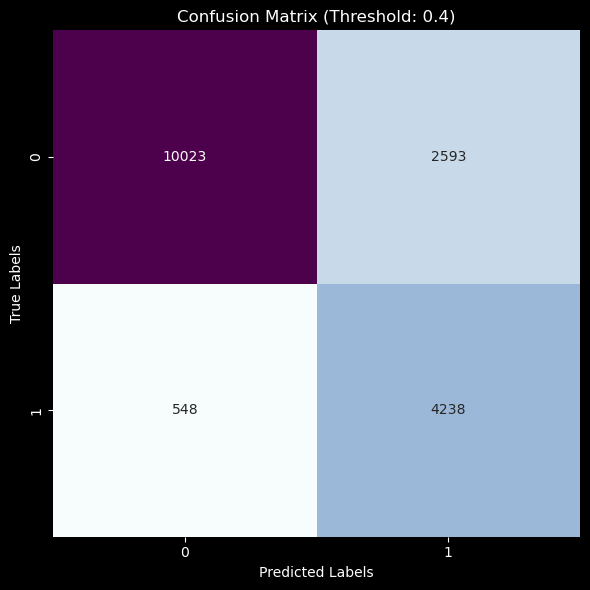

              precision    recall  f1-score   support

           0       0.95      0.79      0.86     12616
           1       0.62      0.89      0.73      4786

    accuracy                           0.82     17402
   macro avg       0.78      0.84      0.80     17402
weighted avg       0.86      0.82      0.83     17402



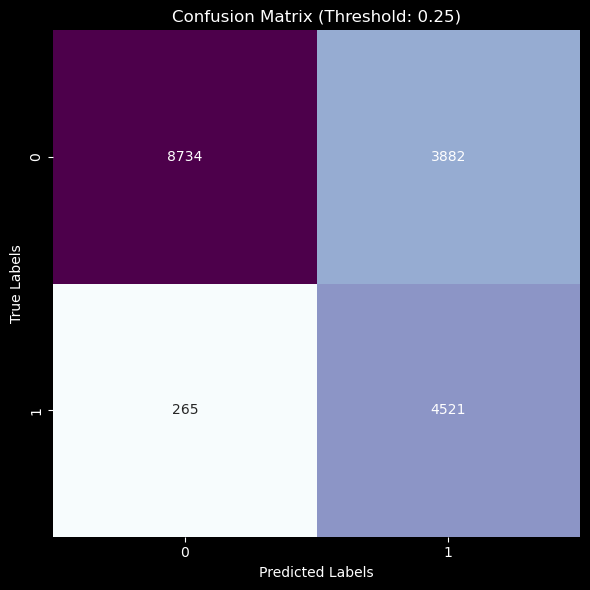

              precision    recall  f1-score   support

           0       0.97      0.69      0.81     12616
           1       0.54      0.94      0.69      4786

    accuracy                           0.76     17402
   macro avg       0.75      0.82      0.75     17402
weighted avg       0.85      0.76      0.77     17402



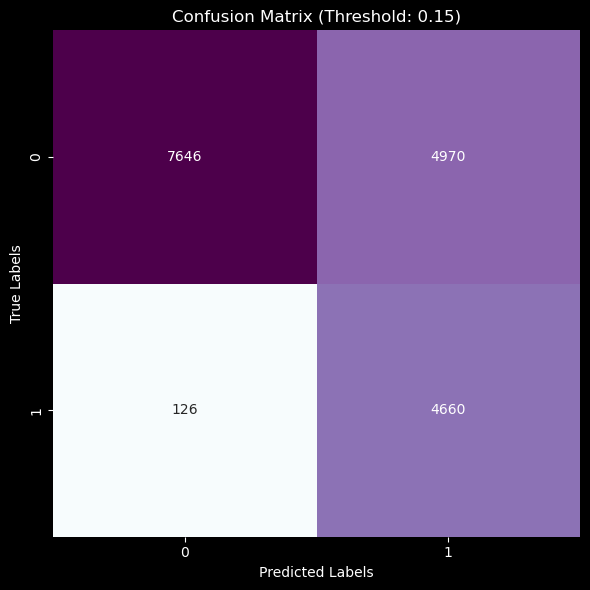

              precision    recall  f1-score   support

           0       0.98      0.61      0.75     12616
           1       0.48      0.97      0.65      4786

    accuracy                           0.71     17402
   macro avg       0.73      0.79      0.70     17402
weighted avg       0.85      0.71      0.72     17402



In [30]:
# define predicting thresholds need to use in mapping the business metrics
thresholds = [0.75,0.52,0.4,0.25,0.15]


for i in thresholds:
    # classify base on the new threshold
    y_pred_bm = (cat_test.predict_proba(X_test)[:,1]>i).astype('float') 
    
    cm_bm = confusion_matrix(y_test,y_pred_bm)
    
    # plot
    plt.figure(figsize=(6,6))
    sns.heatmap(cm_bm, annot=True, cmap='BuPu', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix (Threshold: {i})')
    plt.tight_layout()
    plt.show()
    
    # classification report
    print(classification_report(y_test,y_pred_bm))